In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance
from statsmodels.distributions.empirical_distribution import ECDF
import datetime
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions,histfit
import fitter
import math
import random
from numpy import exp

from scipy.optimize import curve_fit

import json

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
font = {'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

In [3]:
res='results/'

### MiD data
mobilität in deutschland

In [ ]:
# data reading
'''
wegkm: wegelänge, path length
hvm: hauptverkehrsmittel, main mode of transport
hvm_diff2: hauptverkehrsmittel (stärker differenziert), more differentiated

'''
df_MiD=pd.read_csv('data/MiD2017_Wege.csv',decimal=',',sep=';',usecols=['wegkm','hvm','hvm_diff2'])

#exclude unwanted lines with "unknown" distance value et al
df_MiD=df_MiD[df_MiD.wegkm.isin([9994,9999,70703]) == False]


In [5]:
df_MiD_walk =df_MiD[df_MiD.hvm.isin([1]) == True] # Walk
df_MiD_bike = df_MiD[df_MiD.hvm.isin([2]) == True] # Bicycle (incl. Ebike)
df_MiD_autopass = df_MiD[df_MiD.hvm.isin([3]) == True] # Auto Passengers
df_MiD_autodriver = df_MiD[df_MiD.hvm.isin([4]) == True] # Auto Drivers

df_MiD_public=df_MiD[df_MiD.hvm.isin([5]) == True] #public
# Public Transport w/o long distance vehicles,short range
df_MiD_SRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([19,20,21,22,23])==False] 
# long range
df_MiD_LRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([20,21,22,23])==True] 

In [39]:
def ccdf_draw(datalist,labels):
    fig, ax = plt.subplots(figsize=(10,8))
    for i,data in enumerate(datalist):
        sorted_data = np.sort(data)
        linspaced = np.linspace(0, 1, len(data), endpoint=False)
#         print(np.interp(3, sorted_data,linspaced))
        
        ax.plot(sorted_data, 1-linspaced, 'o-',label=labels[i],rasterized=False,markersize=3)
    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
#     plt.ylim(1e-04,1e+0)  # untere+obere grenze von y
    plt.xlim(left=1e-1)  # untere+obere grenze von x
    plt.grid()
#     plt.show()
#     plt.ylim((0,1))
    plt.tight_layout()
    plt.savefig(res+'CCDF in MiD2017_with PT.png', dpi=100, bbox_inches='tight')


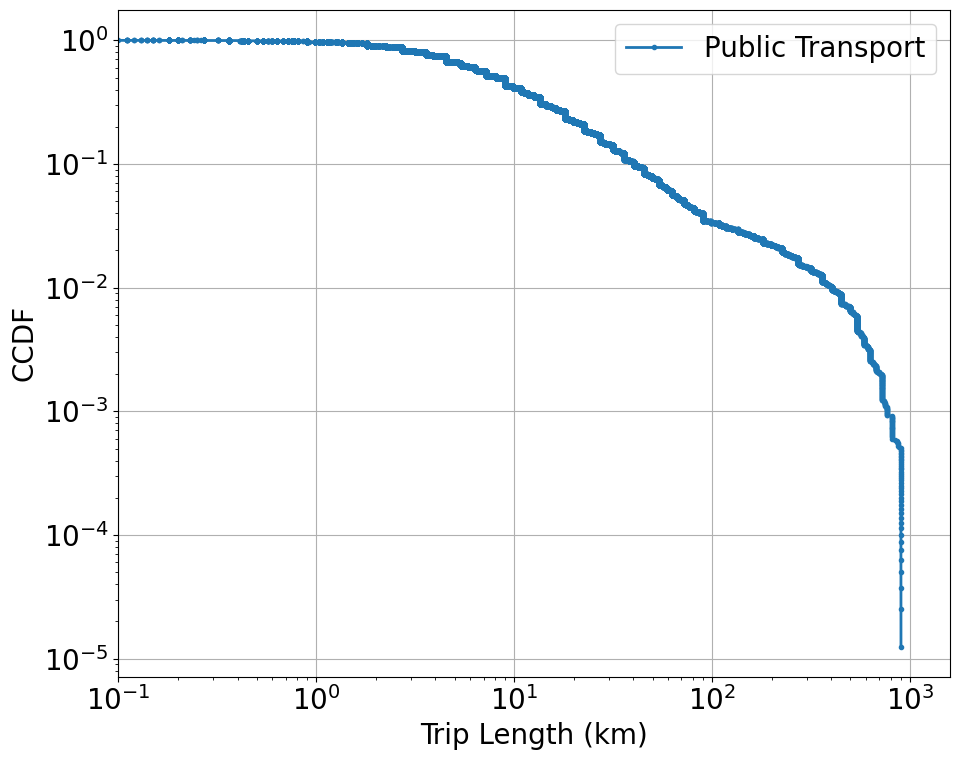

In [40]:
df_MiD_total=pd.concat([df_MiD_walk,df_MiD_bike,df_MiD_autopass,df_MiD_autodriver,df_MiD_public])
# datalist=[df_MiD_total['wegkm'],df_MiD_walk['wegkm'],df_MiD_bike['wegkm'],df_MiD_autodriver['wegkm'],df_MiD_SRpublic['wegkm'],df_MiD_LRpublic['wegkm']]
# labels=['All modes','Walk','Bike','Car','Short Range','Long Range']

datalist=[df_MiD_total['wegkm'],df_MiD_walk['wegkm'],df_MiD_bike['wegkm'],df_MiD_autodriver['wegkm'],df_MiD_public['wegkm']]
labels=['All Modes','Walk','Bike','Car','Public Transport']

ccdf_draw(datalist,labels)

### NHTS17 data
Travel behavior of the American public

trippub.csv:
data items collected for each trip made by each household member age 5+ on the household’s travel day (one record for each trip each person age 5+ made).

In [6]:
# data reading

df_Nhts=pd.read_csv('data/trippub.csv',decimal='.',sep=',',usecols=["TRPMILES", "TRPTRANS","WHYTRP1S"])

df_Nhts.head(10)

,TRPMILES,TRPTRANS,WHYTRP1S
0,5.244,3,20
1,5.149,3,1
2,84.004,6,1
3,81.628,6,10
4,2.250,3,20
5,2.243,3,1
6,8.017,6,10
7,8.017,6,1
8,3.395,4,50
9,3.395,4,1


In [7]:
# ------New--------
df_Nhts_walk =df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([1]) == True]*1.60934 # Walk and transform to km
df_Nhts_bike = df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([2]) == True]*1.60934 # Bicycle and transform to km
#3auto 4suv 5van 6 pick up truck 18rentalcar
df_Nhts_auto=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([3,4,5,6,18])==True]*1.60934   #Auto
# Public Transport short range
#10school bus, 11public bus, 12paratransit / dial-a-ride, 13private/charter/tour/shutnhtse bus, 15amtrack / commuter rail, 16subway, 17taxi /limo (incl uber)
df_Nhts_SRpublic=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([10,11,12,13,16,17])==True]*1.60934  
# long range
#14City-to-city bus (Greyhound, Megabus), 19Airplane, 20Boat/ferry/water taxi
df_Nhts_LRpublic=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([14,19,20])==True]*1.60934  
df_Nhts_total=pd.concat([df_Nhts_walk,df_Nhts_bike,df_Nhts_auto,df_Nhts_SRpublic,df_Nhts_LRpublic])

In [16]:
def ccdf_draw(datalist,labels):
    fig, ax = plt.subplots(figsize=(10,8))
    for i,data in enumerate(datalist):
        sorted_data = np.sort(data)
        linspaced = np.linspace(0, 1, len(data), endpoint=False)
#         print(np.interp(3, sorted_data,linspaced))
        
        ax.plot(sorted_data, 1-linspaced, 'o-',label=labels[i],rasterized=False,markersize=3)
    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
#     plt.ylim(1e-04,1e+0),  # untere+obere grenze von y
    plt.xlim(left=1e-0)  # untere+obere grenze von x
    plt.grid()
#     plt.show()
#     plt.ylim((0,1))
    plt.tight_layout()
    plt.savefig(res+'CCDF in NHTS.pdf', dpi=100, bbox_inches='tight')


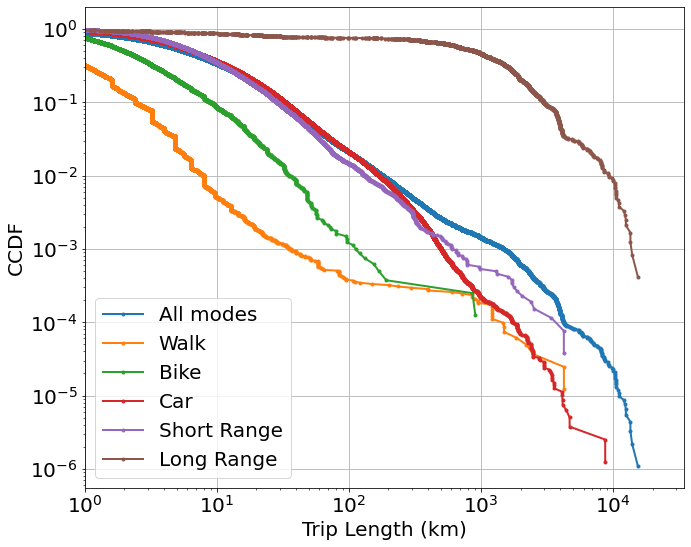

In [17]:
datalist=[df_Nhts_total,df_Nhts_walk,df_Nhts_bike,df_Nhts_auto,df_Nhts_SRpublic,df_Nhts_LRpublic]
labels=['All modes','Walk','Bike','Car','Short Range','Long Range']
ccdf_draw(datalist,labels)

In [10]:
print(
    df_MiD_bike['wegkm'].shape, # bike in MiD 2017
    df_MiD_autodriver['wegkm'].shape, # Auto Driver in MiD 2017
    df_MiD_SRpublic['wegkm'].shape, #Short range public in MiD 2017
    df_MiD_LRpublic['wegkm'].shape, # Long Range in MiD 2017  
    df_Nhts_bike.shape ,# bike in Nhts17
    df_Nhts_auto.shape ,#Auto Driver in Nhts 17
    df_Nhts_SRpublic.shape, #Short range public in Nhts17
    df_Nhts_LRpublic.shape )# Long Range in Nhts17

(102237,) (404637,) (74215,) (4884,) (8034,) (797169,) (26273,) (2401,)


## Modelling

In [46]:
'''
Compute the distance between two 1D distributions.
Can be different length of these two distributions

d1,d2: the distribution, should be the type of List or pd.Series
'''

def custom_distance(d1,d2):
    if type(d1)==np.ndarray or type(d1)==list or type(d1)==pd.Series:
        if type(d2)==np.ndarray or type(d2)==list or type(d2)==pd.Series:
            # find the overlap of two distributions
            min_d=max(min(d1),min(d2))
            max_d=min(max(d1),max(d2))
        else:
            print('Wrong: Data type is not ndarray, List or pd.Series')
    else:
        print('Wrong: Data type is not ndarray, List or pd.Series')
    # re-sampling
    # given the point x value and whole data, calculate the point of y value in CCDF
    sorted_d1 = np.sort(d1)
    linspaced1 = np.linspace(0, 1, len(sorted_d1), endpoint=False)
    y_d1=1-linspaced1
    
    sorted_d2 = np.sort (d2)
    linspaced2 = np.linspace(0, 1, len(sorted_d2), endpoint=False)
    y_d2=1-linspaced2
    
    distance=0
    # number of linearly spaced numbers
    num=1000
    a = np.linspace(min_d,max_d,num)  
    
    for i in a:
        b1=np.interp(i, sorted_d1,y_d1)
        b2=np.interp(i, sorted_d2,y_d2)
        
        e=abs(b1-b2)/((b1+b2)/2)
        
        distance=distance+e
    return distance/num


In [47]:
# df_vec=df_MiD_walk['wegkm'].copy() # bike in MiD 2017
# df_vec=df_MiD_bike['wegkm'].copy() # bike in MiD 2017
# df_vec=df_MiD_autodriver['wegkm'].copy() # Auto Driver in MiD 2017
# df_vec=df_MiD_SRpublic['wegkm'].copy() #Short range public in MiD 2017
df_vec=df_MiD_LRpublic['wegkm'].copy() # Long Range in MiD 2017

# df_vec=df_Nhts_bike.copy() # bike in Nhts17
# df_vec=df_Nhts_auto.copy() #Auto Driver in Nhts 17
# df_vec=df_Nhts_SRpublic.copy() #Short range public in Nhts17
# df_vec=df_Nhts_LRpublic.copy() # Long Range in Nhts17

#number of trips to be generated for each parameter combination. high influence on calculation time!
# sampleNumber_model=800
sampleNumber_model=20000
# sampleNumber_visualization=10000


# t_err_min_distance=5
# t_err_max_distance=40

# select the data between min distance 10km and max distance 1000km
min_distance=10
max_distance=900
# Dynamic max distance
maxdistance=900
df_vec=df_vec[df_vec.between(min_distance,max_distance)]
# df_vec=df_vec[df_vec>=10]
df_vec.shape

(4199,)

In [48]:
#params range, definition

# ----new for mid
eps_range=[1]
p_range=[0]
# alp_range=[1.015]
alp_range=np.arange(1.01,1.2,0.01)

# ----new for mid
# eps_range=np.arange(0.9,1.8,0.02)
# p_range=np.arange(0.7, 0.99, 0.01)
# alp_range=np.arange(1.02,1.3,0.02)

# ----new for Nhts
# eps_range=np.arange(0.8,1.8,0.01)
# p_range=np.arange(0.7, 0.99, 0.01)
# alp_range=np.arange(1.02, 1.6,0.05)

# eps_range=[0.5]# ----new for nhts
# p_range=[1]#0.05 ----new for nhts
# alp_range=[1.02]


err=[0]
combinable=[[eps,p,alp,0,0] for eps in eps_range for p in p_range for alp in alp_range for error in err] #list
for i in range(2):
    print (combinable[i])
print(len(eps_range)*len(p_range)*len(alp_range))

[1, 0, 1.01, 0, 0]
[1, 0, 1.02, 0, 0]
19


In [49]:
%%time

'''
main process of the modelling
alternative approach to avoid : 
select a number from geometric distribution instead of  normal distribution

'''
tmp_max=(maxdistance/2) # a half of possible maximum distance
for i in range(len(combinable)):
    if i%100==0:
        print(i)
        print ("Current date and time : ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    eps=combinable[i][0]
    p=combinable[i][1]
    alp=combinable[i][2]
    error=combinable[i][3]
    all_dist=combinable[i][4]
    dist=[]
    for n in range(sampleNumber_model):
        distance=9999999
        '''Dynamic maximum distance
        idea---for long range
        1. random select a start point in Germany
        2. compute the possible (roughly) max distance from the start point to the border
        
        - choose the direction uniformly, find the largest distance
        - choose the big cities (later...)
        
        think as ellipse
        '''
        #Dynamic maximum distance -----method 1
#         max_distance=np.random.uniform(maxdistance/2, maxdistance)
        # new Dynamic maximum distance----method 2
#         tmp=np.random.uniform(0,1) # (includes low, but excludes high)
#         max_distance=math.sqrt(1-tmp)*tmp_max+tmp_max
        while(distance>=max_distance or distance<min_distance):
            # np.random.uniform(0,1,1) generates one uniform random number between 0 and 1.
            # let sp be drawn from pow(alpha)
            sp=np.random.uniform(0,1,1)**(-1/(alp-1))
            
            '''
            another approach
            '''
            ## alter: select a number (n) from geometric distribution like (1-p)
            # distance=((1+eps)^n)*distance
            distance=sp[0]
#             number=np.random.geometric(p,1)[0]
            number=np.random.geometric(1-p,1)[0]
            
            distance=((1+eps)**(number-1))*distance

        dist.append(distance)
      
    combinable[i][4]=dist
    # method 2 to compute the error
    # wasserstein_distance
    error=custom_distance(dist,df_vec)
#     error=wasserstein_distance(dist,df_vec)
#     df_dist=pd.Series(dist)
    combinable[i][3]=error


0
Current date and time :  2023-03-29 10:00:54


<timed exec>:37: RuntimeWarning: overflow encountered in power


CPU times: user 50.1 s, sys: 861 ms, total: 50.9 s
Wall time: 55.9 s


In [50]:
# Convert to df and save
df_com=pd.DataFrame(combinable)

# df_com.to_pickle(res+'Bike(1-100km) in MiD17.pkl')
# df_com=pd.read_pickle(res+'model paras of Bike in Nhts17.pkl')

combinable=df_com.values.tolist()

In [ ]:
#line 0 auto driver

# #line 1 handpicked
# eps1=2
# p1=0.7
# alp1=1.1
# dist1= dist_vec_gen(sampleNumber_visualization,eps1,p1,alp1)

# convert to numpy array
com=np.array(combinable)
print(com.shape)

#line 2 best fit
# which error is the lowest
idx_best=com[:,3].argmin()
eps2 = com[idx_best,0]
p2 = com[idx_best,1]
alp2 = com[idx_best,2]
dist2= com[idx_best,4]

#line 3 worst fit
# idx_worst=com[:,3].argmax()
# eps3 = com[idx_worst,0]
# p3 = com[idx_worst,1]
# alp3 = com[idx_worst,2]
# dist3= com[idx_worst,4]

In [90]:
# Save only the best results to avoid excessive file storage requirements
save_best=pd.DataFrame(combinable[idx_best])
# save_best.to_pickle(res+'Best results of LR(200-2500_5000km) in Nhts17.pkl')


In [52]:
#long range
print(com[:,3].min())
print(eps2,p2,alp2)
# print(eps1,p1,alp1,eps2,p2,alp2,eps3,p3,alp3)

0.26758975723216616
1 0 1.03


In [53]:
def ccdf_draw(datalist,labels):
    fig, ax = plt.subplots(figsize=(10,8))
    for i,data in enumerate(datalist):
        sorted_data = np.sort(data)
        linspaced = np.linspace(0, 1, len(data), endpoint=False)
#         print(np.interp(3, sorted_data,linspaced))
        
        ax.plot(sorted_data, 1-linspaced, 'o-',label=labels[i],rasterized=False,markersize=3)
    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
#     plt.ylim(1e-04,1e+0),  # untere+obere grenze von y
#     plt.xlim(1e-1,1e+3),  # untere+obere grenze von x
#     plt.xlim(left=200,right=5000)
#     plt.xticks([200,1000,5000],[200,1000,5000])
#     ax.xaxis.set_ticks([200,1000,2000,3000,4000,5000])
    plt.grid()
#     plt.show()
#     plt.ylim((0,1))
    plt.tight_layout()
    plt.savefig(res+'CCDF of temporary.pdf', dpi=100, bbox_inches='tight')


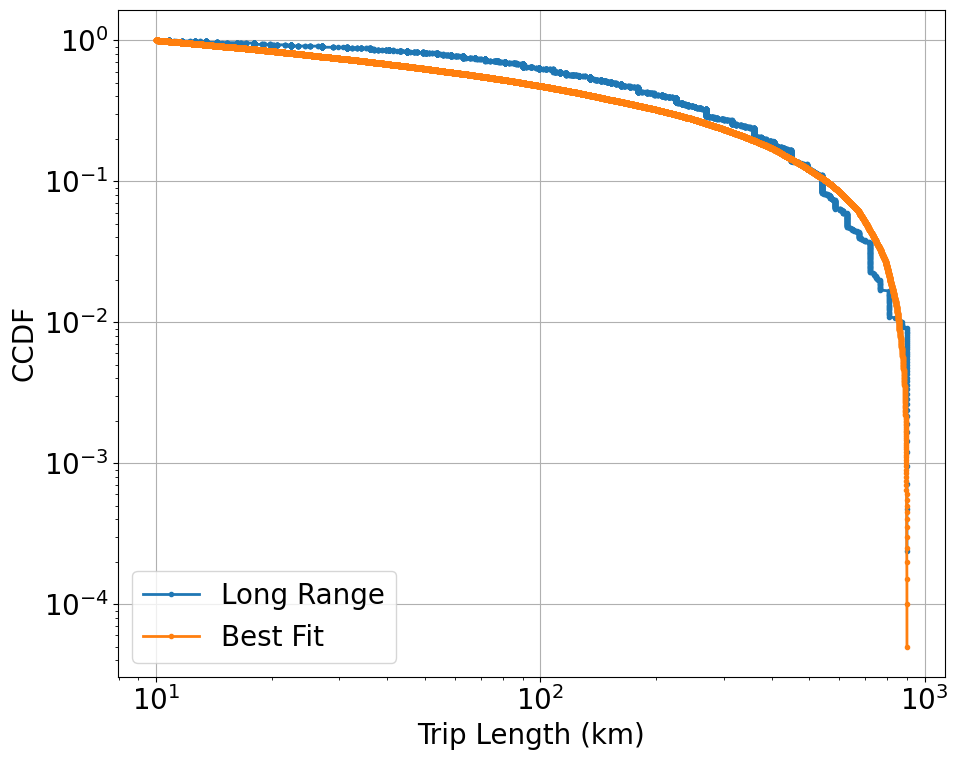

In [54]:
'''
Plotting
'''
datalist=[df_vec,dist2]
labels=['Long Range','Best Fit']
ccdf_draw(datalist,labels)

## Modelling II

find the funtion $f(x)=C* \left( \dfrac{1}{x}\right) ^{\alpha}$ between two specific points for each dataset
 
then calculate the error ( MSE or $error=\sum_{n=1}^{1000}\dfrac{|f(x_i)-g(x_i)|}{\dfrac{ f(x_i)+g(x_i)}{2}}$ ) between the function above and real data

In [23]:
df_vec=df_MiD_walk['wegkm'].copy() # walk in MiD 2017
# df_vec=df_MiD_bike['wegkm'].copy() # bike in MiD 2017
# df_vec=df_MiD_autodriver['wegkm'].copy() # Auto Driver in MiD 2017
# df_vec=df_MiD_SRpublic['wegkm'].copy() #Short range public in MiD 2017
# df_vec=df_MiD_LRpublic['wegkm'].copy() # Long Range in MiD 2017

# df_vec=df_Nhts_bike.copy() # bike in Nhts17
# df_vec=df_Nhts_auto.copy() #Auto Driver in Nhts 17
# df_vec=df_Nhts_SRpublic.copy() #Short range public in Nhts17
# df_vec=df_Nhts_LRpublic.copy() # Long Range in Nhts17

#number of trips to be generated for each parameter combination. high influence on calculation time!
# sampleNumber_model=800
sampleNumber_model=1000
sampleNumber_visualization=10000

t_err_min_distance=3
t_err_max_distance=30

# select the data between min distance 10km and max distance 1000km
min_distance=1
max_distance=100
df_vec=df_vec[df_vec.between(min_distance,max_distance)]
# df_vec=df_vec[df_vec>=10]
df_vec.shape

(69987,)

In [24]:

# given the point x value and whole data, calculate the point of y value in CCDF
def cal_y_ccdf(data,x):
    
    sorted_data = np.sort(data)
    linspaced = np.linspace(0, 1, len(data), endpoint=False)
    y=1-linspaced
    
    return np.interp(x, sorted_data,y)


In [25]:

# get C and alpha
X1=t_err_min_distance
X2=t_err_max_distance
Y1=cal_y_ccdf(df_vec,X1)
Y2=cal_y_ccdf(df_vec,X2)
# print(Y1,Y2)
alp=(math.log(Y1)-math.log(Y2))/(math.log(X2)-math.log(X1))
C=Y1*(X1**alp)
print(alp,C)
print(Y1,Y2)

2.2583021067805387 3.8936341469316673
0.32574008642421354 0.001797086991480265


In [26]:

def ccdf_draw(data,lb,X1,X2,C,alp):
    fig, ax = plt.subplots(figsize=(10,8))
    sorted_data = np.sort(data)
    linspaced = np.linspace(0, 1, len(data), endpoint=False)
#         print(np.interp(3, sorted_data,linspaced))

    ax.plot(sorted_data, 1-linspaced, 'o-',label=lb,rasterized=False,markersize=3,alpha=0.6)
    
    # 100 linearly spaced numbers
    s = np.linspace(X1,X2,500)
    # the function
    t = C/(s**alp)
    
    distance=0
    for i in s:
        t1=cal_y_ccdf(data,i)
        t2=C/(i**alp)
        e=abs(t1-t2)/((t1+t2)/2)
        distance+=e
        
#     error=custom_distance(data,s)
    print('the distance is', distance/500)

    # plot the function
    ax.plot(s,t, 'r',linewidth=3.5)
        
    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
#     plt.ylim(1e-04,1e+0),  # untere+obere grenze von y
#     plt.xlim(4,50),  # untere+obere grenze von x
#     plt.xlim(left=200,right=5000)
#     plt.xticks([200,1000,5000],[200,1000,5000])
#     ax.xaxis.set_ticks([200,1000,2000,3000,4000,5000])
    plt.grid()
#     plt.show()
#     plt.ylim((0,0.4))
    plt.tight_layout()
#     plt.savefig(res+'test.pdf', dpi=100, bbox_inches='tight')
    plt.savefig(res+'real Walk in MiD17.png', dpi=100, bbox_inches='tight')


the distance is 0.26174516445801543


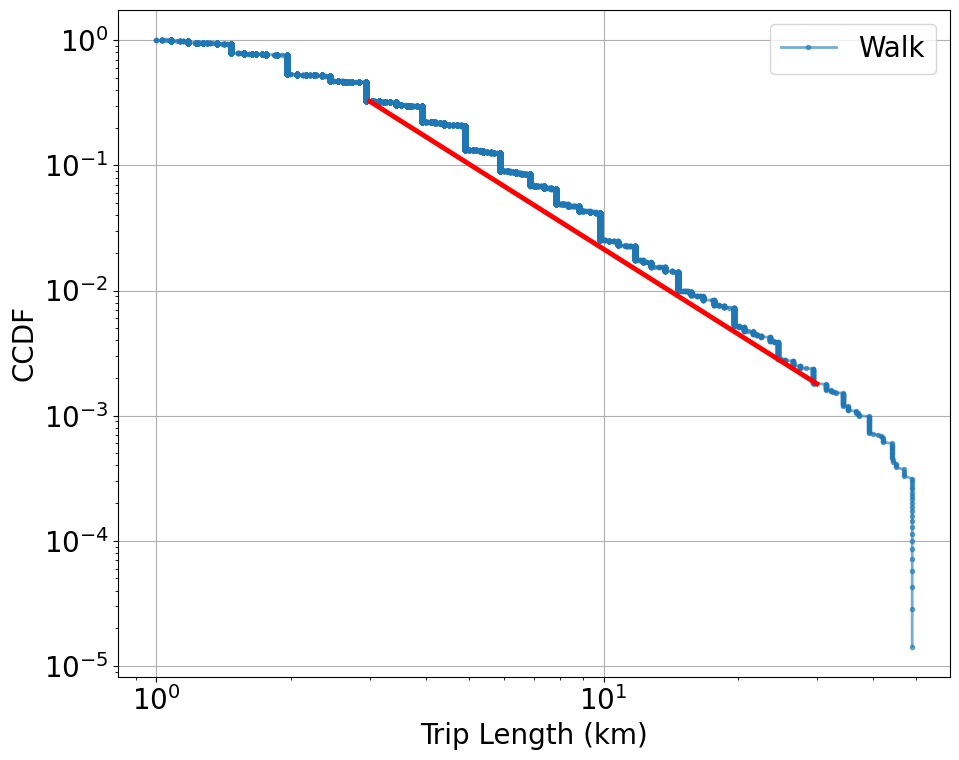

In [27]:
ccdf_draw(df_vec,'Walk',X1,X2,C,alp)

## Finding the Possible Distribution that Fits the Data Long Range in MiD 2017

In [8]:
df_vec=df_MiD_LRpublic['wegkm'].copy() # Long Range in MiD 2017
# df_vec=df_MiD_bike['wegkm'].copy() # bike in MiD 2017
# df_vec=df_MiD_autodriver['wegkm'].copy() # Auto Driver in MiD 2017
# df_vec=df_MiD_SRpublic['wegkm'].copy() #Short range public in MiD 2017

# df_vec=df_Nhts_bike.copy() # bike in Nhts17
# df_vec=df_Nhts_auto.copy() #Auto Driver in Nhts 17
# df_vec=df_Nhts_SRpublic.copy() #Short range public in Nhts17
# df_vec=df_Nhts_LRpublic.copy() # Long Range in Nhts17

# select the data between min distance 10km and max distance 1000km
# min_distance=1
# max_distance=100
# df_vec=df_vec[df_vec.between(min_distance,max_distance)]
# df_vec=df_vec[df_vec>=10]
df_vec.shape

(4884,)

In [10]:
'''
averages each bin with its neighboring bins
n_neighbors is the number of choosen neighbors(right side)
'''
def avg_neighbors(hist, n_neighbors=1):
    new_hist = np.zeros_like(hist)
    for i in range(len(hist)):
        start = max(0, i - n_neighbors)
        end = min(len(hist), i + n_neighbors + 1)
        new_hist[i] = np.mean(hist[start:end])
    return new_hist

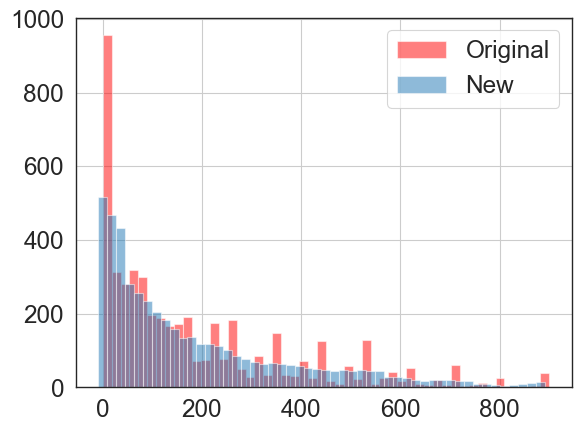

In [44]:
n_bins = 50 #number of bins
hist, bin_edges = np.histogram(df_vec, bins=n_bins) #bins here is bin edges or bin width

new_hist = avg_neighbors(hist, n_neighbors=2)
plt.hist(df_vec, bins=bin_edges, alpha=0.5, label='Original', color='red')
plt.bar(bins[:-1], new_hist, width=np.diff(bins), alpha=0.5, label='New')
plt.grid()
plt.legend()
plt.show()

In [12]:
hist,bins,new_hist

(array([955, 312, 282, 319, 300, 196, 188, 168, 171, 191,  72,  75, 176,
         78, 184,  50,  29,  86,  33, 147,  34,  31,  71,  27, 127,  17,
         10,  57,  23, 128,  10,  26,  43,  18,  52,   9,   7,  20,   6,
         62,   4,   7,  13,   0,  25,   0,   1,   2,   4,  38]),
 array([1.000000e-02, 1.800980e+01, 3.600960e+01, 5.400940e+01,
        7.200920e+01, 9.000900e+01, 1.080088e+02, 1.260086e+02,
        1.440084e+02, 1.620082e+02, 1.800080e+02, 1.980078e+02,
        2.160076e+02, 2.340074e+02, 2.520072e+02, 2.700070e+02,
        2.880068e+02, 3.060066e+02, 3.240064e+02, 3.420062e+02,
        3.600060e+02, 3.780058e+02, 3.960056e+02, 4.140054e+02,
        4.320052e+02, 4.500050e+02, 4.680048e+02, 4.860046e+02,
        5.040044e+02, 5.220042e+02, 5.400040e+02, 5.580038e+02,
        5.760036e+02, 5.940034e+02, 6.120032e+02, 6.300030e+02,
        6.480028e+02, 6.660026e+02, 6.840024e+02, 7.020022e+02,
        7.200020e+02, 7.380018e+02, 7.560016e+02, 7.740014e+02,
        7.92

### Generate artificial data according the smoothed histogram
then find the possible distributions for fitting the artificial raw data.

In [24]:
# Normalize the bin heights
total = sum(new_hist)
norm_heights = [h/total for h in new_hist]
len(norm_heights)

50

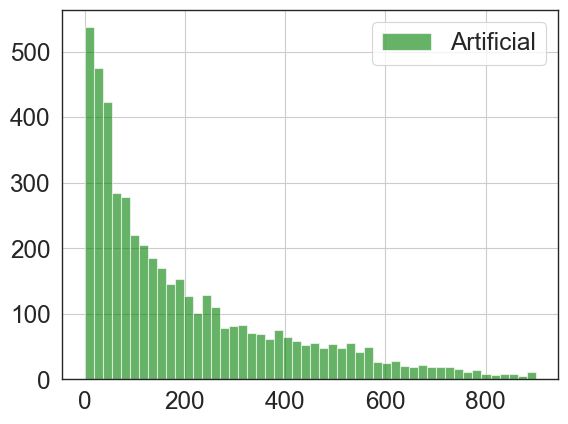

In [48]:
# Calculate the bin widths and heights
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Generate artificial data based on the histogram plot
n_samples = df_vec.shape[0]
arti_data = []
for i in range(n_samples):
    bin = np.random.choice(len(norm_heights), p=norm_heights)
    x = np.random.uniform(bin_edges[bin], bin_edges[bin+1])
    arti_data.append(x)

# Plot the artificial data histogram
plt.hist(arti_data, bins=bin_edges,alpha=0.6,label='Artificial', color='green')
plt.grid()
plt.legend()
plt.show()

Fitting 11 distributions: 100%|█████████████████| 11/11 [00:02<00:00,  3.82it/s]


(0.0, 0.01)

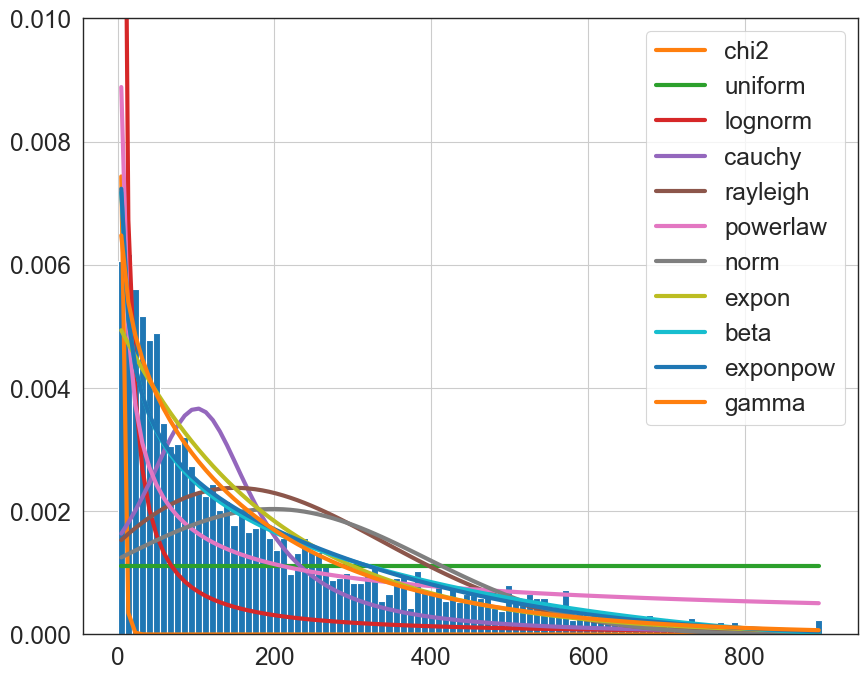

In [53]:

# f = Fitter(data)
f = Fitter(arti_data,
           bins=100,
           distributions=['cauchy',
                         'chi2',
                         'beta',
                         'expon',
                         'exponpow',
                         'gamma',
                         'lognorm',
                         'norm',
                         'powerlaw',
                         'rayleigh',
                         'uniform'])

f.fit()
fig, ax = plt.subplots(figsize=(10,8))
f.summary(Nbest=11,lw=3,method='ks_pvalue')
plt.ylim(0,0.01)

### Define multiple functions to use in curve_fit() function
$y=ax^2+bx+c$

$y=ax^3+bx+c$

$y=ax^3+bx^2+c$

$y=a\exp^{bx}+c$

In [77]:
''' Curve fit: fitting a two dimension data, find a curve to fit the smoothed histogram
Use non-linear least squares to fit a function, f, to data.

return: params -->Optimal values for the parameters so that the sum of 
                the squared residuals of f(xdata, *popt) - ydata is minimized.

'''
x=bins[1:]#bins here is bin edges or bin width, means the value on left or right side of each bin
y=new_hist

def func1(x, a, b, c):
    return a*x**2+b*x+c

def func2(x, a, b, c):
    return a*x**3+b*x+c

def func3(x, a, b, c):
    return a*x**3+b*x**2+c

def func4(x, a, b, c):
    return a*exp(b*x)+c

params, covs = curve_fit(func1, x, y)
print("params: ", params)
print("covariance: ", covs)

params:  [ 9.27339544e-04 -1.20726379e+00  3.90414012e+02]
covariance:  [[ 1.10845333e-08 -1.01757102e-05  1.58746032e-03]
 [-1.01757102e-05  9.93899542e-03 -1.73160261e+00]
 [ 1.58746032e-03 -1.73160261e+00  3.93571436e+02]]


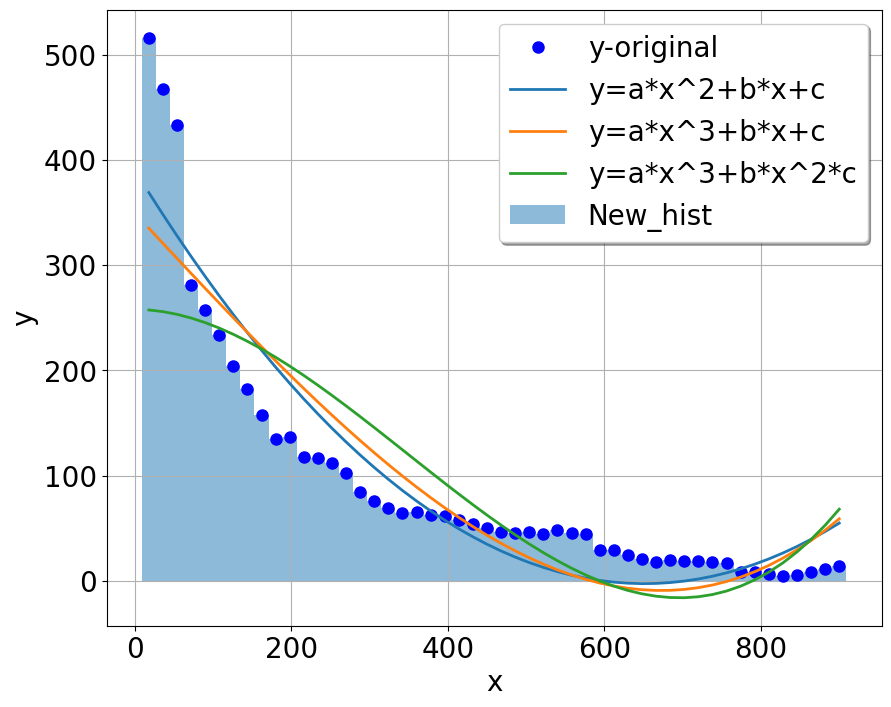

In [91]:
params1, _ = curve_fit(func1, x, y)
a, b, c = params1[0], params1[1], params1[2]
yfit1 = a*x**2+b*x+c

params2, _  = curve_fit(func2, x, y)
a, b, c = params2[0], params2[1], params2[2]
yfit2 = a*x**3+b*x+c

params3, _  = curve_fit(func3, x, y)
a, b, c = params3[0], params3[1], params3[2]
yfit3 = a*x**3+b*x**2+c

# params4, _  = curve_fit(func4, x, y)
# a, b, c = params4[0], params4[1], params4[2]
# yfit4 = a*exp(x*b)+c

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(x, y, 'bo',label="y-original")
plt.plot(x, yfit1, label="y=a*x^2+b*x+c")
plt.plot(x, yfit2, label="y=a*x^3+b*x+c")
plt.plot(x, yfit3, label="y=a*x^3+b*x^2*c")
plt.bar(bins[1:], new_hist, width=np.diff(bins), alpha=0.5, label='New_hist')
# plt.plot(x, yfit4, label="y=a*exp(b*x)+c")
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show() 
